'\n\n\nnum_episodes = 1000\n\napproximator = TileCodeing(env,200,4)\nrmse = RMSE(true_value, approximator, num_episodes)\ngradient_monte_carlo(env, approximator, num_episodes, 2e-5,callback=rmse)\n\nv_hats = np.zeros(env.num_states)\nfor s in range(env.num_states):\n    v_hats[s] = approximator.predicate(s)\n\nplt.ylim((-1,1))\nplt.plot(range(len(true_value)),true_value)\nplt.plot(range(len(v_hats)), v_hats)\nplt.show()\nplt.plot(range(len(rmse.rmse)), rmse.rmse)'

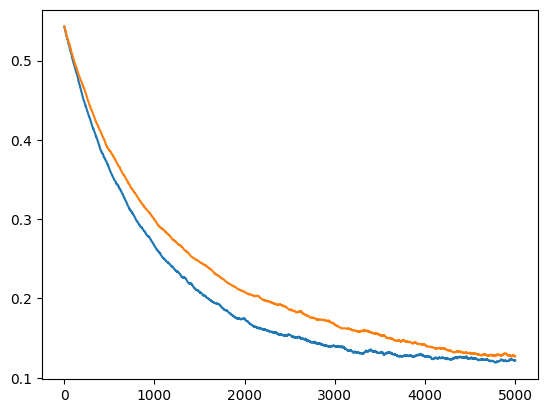

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import math
import profile

def random_walk_true_value(num_states, trans_len):
    trans_prob = 0.5 / trans_len
    order = num_states
    i = np.identity(order)
    t = np.zeros_like(i)
    for row in range(order):
        for col in range(order):
            dis = row - col
            if dis >= -trans_len and dis <= trans_len and dis != 0:
                t[row][col] = trans_prob

    b = np.zeros(order)
    for row in range(order):
        for n in range(trans_len):
            if row - n - 1 < 0:
                b[row] -= trans_prob
            if row + n + 1 >= order:
                b[row] += trans_prob
    m = i - t
    s = np.linalg.solve(m,b)
    return s


class RandomWalk:
    def __init__(self, num_states, trans_len):
        self.num_states = num_states
        self.trans_len = trans_len
        self.state = self.num_states // 2
       
    def reset(self):
        self.state = self.num_states // 2
        return self.state

    def step(self):
        offset = np.random.randint(-self.trans_len, self.trans_len)
        if offset >=0:
            offset += 1
        self.state += offset
        if self.state < 0:
            return -1, self.num_states
        elif self.state < self.num_states:
            return 0, self.state
        else:
            return 1, self.num_states
        
    def is_terminated(self, state):
        return state >= self.num_states
    
class StateAggregation:
    def __init__(self, env, num_groups):
        self.num_states = env.num_states
        self.num_groups = num_groups
        self.reset()

    def reset(self):
        self.w = np.zeros(self.num_groups)

    def to_features(self, states):
        states = np.array(states).reshape(-1,1)
        poses = states * self.num_groups // self.num_states
        #poses = (states - self.starts) // self.tile_size + np.arange(0, self.num_tilings) * self.tiles_per_tiling
        #print(states.shape, poses.shape)
        return poses

    #def aggregated_state(self, state):
    #    return state * self.num_groups // self.num_states

    def predicate(self, states):
        features = self.to_features(states)
        v_hat = self.w[features].reshape(-1)
        #print(agg_state.shape,v_hat.shape)
        return v_hat
    
    def train(self, states, target, alpha):
        features = self.to_features(states)
        v_hat = self.w[features]
        self.w[features] += (target - v_hat) * alpha

class TileCodeing:
    def __init__(self, env, tile_size, tile_offset):
        self.num_states = env.num_states
        self.tile_size = tile_size
        self.tile_offset = tile_offset

        first_start = tile_offset - tile_size
        
        self.num_tilings = (- first_start) // tile_offset + 1
        self.tiles_per_tiling = self.num_states // tile_size + 1

        self.starts = np.arange(first_start, tile_offset, tile_offset, dtype=int)

        #self.indices = np.arange(self.num_tilings, dtype=int)
        self.w = np.zeros(self.num_tilings * self.tiles_per_tiling)

    def reset(self):
        self.w = np.zeros(self.num_tilings * self.tiles_per_tiling)

    def to_features(self, states):
        states = np.array(states).reshape(-1,1)
        poses = (states - self.starts) // self.tile_size + np.arange(0, self.num_tilings) * self.tiles_per_tiling
        #print(states.shape, poses.shape)
        return poses

    def predicate(self, states):
        features = self.to_features(states)
        v_hat = self.w[features].sum(axis=1)
        #print(features.shape,v_hat.shape)
        return v_hat
    
    def train(self, states, target, alpha):
        features = self.to_features(states)
        v_hat = self.w[features].sum()
        self.w[features] += alpha * (target - v_hat)


def gradient_monte_carlo(env, approximator, num_episodes, alpha, gamma = 1.0, callback = None):
    for episode in range(num_episodes):
        state = env.reset()
        rewards = []
        states = [state]
        while True:
            reward, next_state = env.step()
            rewards.append(reward)
            if next_state >= env.num_states:
                break
            states.append(next_state)
            state = next_state
        g = 0
        for t in range(len(rewards)-1,-1,-1):
            g = g*gamma + rewards[t]
            approximator.train(states[t], g, alpha)
        if callback:
            callback(episode)

class RMSE:
    def __init__(self, true_value, approximator, num_episodes) -> None:
        self.true_value = true_value
        self.approximator = approximator
        self.rmse = np.zeros(num_episodes)

    def __call__(self, episode):
        s = np.arange(self.approximator.num_states).reshape(-1,1)
        v_hats = self.approximator.predicate(s)
        #print(v_hats.shape, self.true_value.shape,(v_hats - self.true_value).shape)
        self.rmse[episode] = np.sqrt(np.power((v_hats - self.true_value),2.0).mean())

num_states = 1000
trans_len = 100
num_episodes = 5000
num_avg = 10
true_value = random_walk_true_value(num_states, trans_len)
env = RandomWalk(num_states, trans_len)


params=[
    [np.zeros(num_episodes), StateAggregation(env, 5), 0.0001],
    [np.zeros(num_episodes), TileCodeing(env, 200,4), 0.0001/50],
]

def test():
    for param in params:
        avg_rmse = param[0]
        approximator = param[1]
        alpha = param[2]
        for n in range(num_avg):
            approximator.reset()
            rmse = RMSE(true_value, approximator, num_episodes)
            gradient_monte_carlo(env, approximator, num_episodes, alpha, callback=rmse)
            avg_rmse += rmse.rmse
        avg_rmse /= num_avg

#profile.run("test()",sort=1)
test()
for param in params:
    avg_rmse = param[0]
    plt.plot(range(len(avg_rmse)), avg_rmse)

'''


num_episodes = 1000

approximator = TileCodeing(env,200,4)
rmse = RMSE(true_value, approximator, num_episodes)
gradient_monte_carlo(env, approximator, num_episodes, 2e-5,callback=rmse)

v_hats = np.zeros(env.num_states)
for s in range(env.num_states):
    v_hats[s] = approximator.predicate(s)

plt.ylim((-1,1))
plt.plot(range(len(true_value)),true_value)
plt.plot(range(len(v_hats)), v_hats)
plt.show()
plt.plot(range(len(rmse.rmse)), rmse.rmse)'''

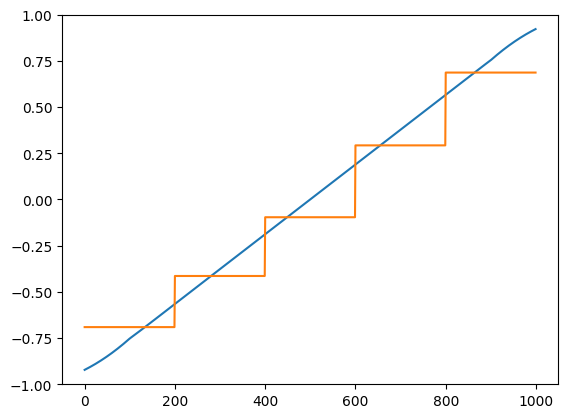

0.10762497433347999


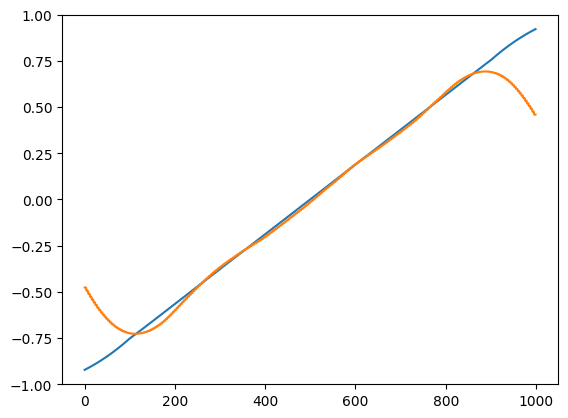

0.057080791149298295


In [147]:
v_hats = np.zeros(env.num_states)
approximator = params[0][1]
for s in range(env.num_states):
    v_hats[s] = approximator.predicate(s)
plt.ylim((-1,1))
plt.plot(range(len(true_value)),true_value)
plt.plot(range(len(v_hats)), v_hats)
plt.show()


s = np.arange(approximator.num_states).reshape(-1,1)
v_hats = approximator.predicate(s)
rmse = np.zeros(num_episodes)
rmse = np.sqrt(np.power((v_hats - true_value),2.0).mean())
print(np.abs(v_hats - true_value).mean())

v_hats = np.zeros(env.num_states)
approximator = params[1][1]
for s in range(env.num_states):
    v_hats[s] = approximator.predicate(s)
plt.ylim((-1,1))
plt.plot(range(len(true_value)),true_value)
plt.plot(range(len(v_hats)), v_hats)
plt.show()

s = np.arange(approximator.num_states).reshape(-1,1)
v_hats = approximator.predicate(s)
rmse = np.zeros(num_episodes)
rmse = np.sqrt(np.power((v_hats - true_value),2.0).mean())
print(np.abs(v_hats - true_value).mean())
